# CS 363M Machine Learning Project

## Authors
- Hudson Gould (HAG929)
- Cristian Cantu (cjc5844)
- Diego Costa (dc48222)
- Dylan Dang (dad4364)

## Background



In this project, we want to predict wether or not a given baseball pitch will be a home run or not. This is an interesting problem because it could be used to better predict the outcomes of baseball games in advance (at least in terms of number of homeruns). Alternatively, one can calculate the probability of a given pitch being a home run *during* the pitch itself (though the outcome will be evident seconds after).

To do this, we are using data from the UT Baseball 2024 Season. Our dataset contains data from every single pitch during UT home games, taken from a TrackMan brand detection machine which tracks and records 3D characteristic of a baseball in motion.

We want to use this data to predict whether a given pitch will be a home run or not. We will use information such as the pitch velocities, runs scored, and other pitch information to predict this. This ML problem is especially interesting, as it suffers from a massive imbalance of classes - far more of the pitches are NOT homeruns, compared to those that are. (Reminiscent of the "predicting credit card fraud" problem). This means that our data will have to be carefully pruned and our modeling techniques must be jucicious to avoid a too-high false negative rate.



## Data Preparation

### Import packages

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spstats
import seaborn as sns
import sklearn as sk

# Render all stand standalone statements 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

### Data Cleaning

##### Print the head of the data as a cursory look

In [ ]:
data = pd.read_csv('data.csv')

print("Shape: ", data.shape)

data.head()

##### Filtering for home games

One notable feature of this data is the enourmous amount of rows - 1.5 Million! Looking at the first column "game_id", we in fact see that multiple other schools are represented in this dataset, since we see names of schools that are not Texas or it's opponent on a given day (for example, the head of this data shows a game from High Point University v Not Texas). 

For this reason, an easy first step is to remove all the rows not containing "Texas" in the first column, to give us a pruned dataset of ONLY Texas home games. We choose to ignore the Away games, as garnering insights to get a better home field advantage is better than trying to analyze our performance at 6 different other school's fields.

In [ ]:
texas_data = data[data['game_id'].str.contains("Texas", na=False)]

texas_data.to_csv("texas_data.csv", index=False)

texas_data.head()

Now that we have our texas_data.csv, we can proceed with our analysis from here!

##### Cleaned home game data

In [109]:
texas_data = pd.read_csv("texas_data.csv")

print("Shape of the data: ", texas_data.shape)

num_rows = texas_data.shape[0]

#Figure out how many games this represents
num_games = texas_data['game_id'].nunique()
print("This data represents", num_games, "games")
print("This means there were an average", num_rows/num_games, "pitches per game")

Shape of the data:  (10230, 77)
This data represents 33 games
This means there were an average 310.0 pitches per game


After reducing our dataset to only the Texas home games, our dataset has a much more manageable 10230 rows. 

##### Understanding the features

Now we want to take a more in-depth look at all of our features and use both logic and analytical methods to identify features which are not useful and then remove them as part of our feature engineering step. For this purpose, it is crucially important to understand what exactly the 77 given features are exactly.

Here are the features and their meanings: (taken from the TrackMan website)

<details>
<summary>Features</summary>

**Game Information**
- **game_id**: Game ID  
- **Date**: Date of the game  
- **Time**: Time of the pitch  
- **Inning**: Inning of the game  
- **inning_half**: Top or Bottom of the inning  
- **PAofInning**: Plate appearance of the inning  
- **PitchofPA**: Pitch number within the plate appearance  

**Pitcher Information**
- **Pitcher**: Name of the pitcher  
- **PitcherId**: Unique identifier for the pitcher  
- **PitcherThrows**: Pitcher's throwing hand (e.g., right or left)  
- **PitcherTeam**: Team of the pitcher  

**Batter Information**
- **Batter**: Name of the batter  
- **BatterId**: Unique identifier for the batter  
- **BatterSide**: Batter's stance (e.g., right or left)  
- **BatterTeam**: Team of the batter  

**Catcher Information**
- **catcher**: Name of the catcher  
- **catcher_id**: Unique identifier for the catcher  
- **catcher_team**: Team of the catcher  

**Pitch Call and Results**
- **PitchCall**: Umpire call for the pitch (e.g., ball, strike)  
- **PlayResult**: Outcome of the play (e.g., single, out, home run)  
- **KorBB**: Strikeout or base on balls indicator  
- **OutsOnPlay**: Number of outs resulting from the play  
- **RunsScored**: Runs scored on the play  

**Game State**
- **Balls**: Count of balls in the at-bat  
- **Strikes**: Count of strikes in the at-bat  
- **Outs**: Number of outs in the inning  

**Pitch Information**
- **TaggedPitchType**: Categorized pitch type (e.g., fastball, curveball)  
- **RelSpeed**: Release speed of the pitch  
- **SpinRate**: Spin rate of the pitch in revolutions per minute  
- **SpinAxis**: Orientation of the spin axis (degrees)  
- **Tilt**: Clock-style representation of spin axis  
- **InducedVertBreak**: Vertical break due to spin (in inches)  
- **VertBreak**: Total vertical break (in inches)  
- **HorzBreak**: Total horizontal break (in inches)  
- **VertApprAngle**: Vertical approach angle at the plate (degrees)  
- **HorzApprAngle**: Horizontal approach angle at the plate (degrees)  
- **zone_time**: Time to reach the strike zone (seconds)  

**Release Metrics**
- **vert_rel_angle**: Vertical release angle of the pitch (degrees)  
- **horz_rel_angle**: Horizontal release angle of the pitch (degrees)  
- **RelHeight**: Release height of the pitch (feet)  
- **RelSide**: Horizontal release position relative to the rubber (feet)  
- **Extension**: Distance from the mound to the release point (feet)  

**Plate Location**
- **PlateLocHeight**: Height of the pitch as it crosses the plate (feet)  
- **PlateLocSide**: Horizontal location of the pitch at the plate (feet)  

**Hit Information**
- **TaggedHitType**: Categorized hit type (e.g., ground ball, fly ball)  
- **hit_x**: X-coordinate of the hit landing spot (feet)  
- **hit_y**: Y-coordinate of the hit landing spot (feet)  
- **ExitSpeed**: Exit velocity of the ball off the bat (mph)  
- **Angle**: Launch angle of the ball (degrees)  
- **HitSpinRate**: Spin rate of the ball off the bat (rpm)  
- **hit_spin_axis** Spin axis of the ball off the bat (degrees)  
- **Distance**: Total distance of the hit (feet)  
- **hit_last_tracked_distance**: Last tracked distance of the ball (feet)  
- **hit_hang_time**: Time the ball is in the air (seconds)  
- **Direction**: Direction of the hit (e.g., pull, opposite)  
- **Bearing**: Bearing of the hit relative to the field (degrees)  
- **hit_max_height**: Maximum height of the ball (feet)  
- **hit_contact_x**: X-coordinate of the contact point on the bat (inches)  
- **hit_contact_y**: Y-coordinate of the contact point on the bat (inches)  
- **hit_contact_z**: Z-coordinate of the contact point on the bat (inches)  

**Pitch Physics**
- **position_110x**: X-position at 110 feet from release point (feet)  
- **position_110y**: Y-position at 110 feet from release point (feet)  
- **position_110z**: Z-position at 110 feet from release point (feet)  
- **pfxx**: Horizontal movement of the pitch (inches)  
- **pfxz**: Vertical movement of the pitch (inches)  
- **x0**: X-coordinate of the pitch at release (feet)  
- **y0**: Y-coordinate of the pitch at release (feet)  
- **z0**: Z-coordinate of the pitch at release (feet)  
- **vx0**: X-component of velocity at release (mph)  
- **vy0**: Y-component of velocity at release (mph)  
- **vz0**: Z-component of velocity at release (mph)  
- **ax0**: X-component of acceleration (ft/s²)  
- **ay0**: Y-component of acceleration (ft/s²)  
- **az0**: Z-component of acceleration (ft/s²)  
- **EffectiveVelo**: Effective velocity as perceived by the batter (mph)  
- **SpeedDrop**: Velocity drop from release to plate (mph)

<details>

##### Remove unneccessary features

While it may be tempting to immediately remove features such as the inning number, we need to do some critical thinking. The only rows which we should drop outright are those which are either too difficult to process or too variant to be meaningful. For example, pitcher name (which is categorical), and the timestamp are 2 good examples of columns we should just drop. However, info like the inning number is useful and may in fact have a correlation with home runs which should not be glossed over. For example, perhaps pitchers tend to get tired by the 9th inning, and thus give up more home runs. Or alternatively, they "lock in" in the final inning to close out a tight game! We don't really know, so it behooves us to keep it in and let analytics to the thinking.

With all this said, we will first remove those obvious "should not use" features. Note that we choose to not include player information simply because one-hot-encoding all the players would result in too many additional features.

In [110]:
cols_to_drop = [
    "game_id",
    "Date",
    "Time",
    "Pitcher",
    "PitcherId",
    "Batter",
    "BatterId",
    "catcher",
    "catcher_id",
    "catcher_team",
    "y0" #We also drop y0 as it is a constant value of 50
]

data = texas_data.drop(columns=cols_to_drop, errors='ignore')

data.shape

(10230, 66)

Note that the number of columns is now down from 77 to 67, (minus 10, which is the length of cols_to_drop)

##### Separate before-hit and after-hit data

As a restatement of our goal, we want to predict wether a given pitch will be a home run given all the data up to (and including) the batter's point of contact. Any information after the fact (like distance, number of runs scored, and the play call) makes it quite easy to infer wether the hit was a home run or not. Thus, we now need to separate all the columns containing after-hit data into a different dataframe. (Not erase it, since it will be useful for accuracy metrics later!)

In [111]:
# now lets drop those columns
after_hit_cols = [
    "PitchCall",
    "PlayResult",
    "KorBB",
    "OutsOnPlay",
    "RunsScored",
    "TaggedHitType",
    "hit_x",
    "hit_y",
    "Distance",
    "hit_last_tracked_distance",
    "hit_hang_time",
    "Direction",
    "Bearing",
    "hit_max_height",
]

print("Shape:", data.shape)

after_hit_data = data[after_hit_cols]
data = data.drop(columns=after_hit_cols)

after_hit_data.head()

#Print after sizes to confirm proper split
print("Pre-hit / Training Data Shape: ", data.shape)
print("After-hit / Testing Data Shape: ", after_hit_data.shape)

data_after_cleaning = data

Shape: (10230, 66)


,PitchCall,PlayResult,KorBB,OutsOnPlay,RunsScored,TaggedHitType,hit_x,hit_y,Distance,hit_last_tracked_distance,hit_hang_time,Direction,Bearing,hit_max_height
0,InPlay,Out,Undefined,1,0,fly_ball,136.25,226.40,264.23,258.01,3.27,23.07,31.04,35.12
1,InPlay,Double,Undefined,0,0,fly_ball,-74.63,349.69,357.56,357.56,4.26,-4.79,-12.05,56.00
2,StrikeCalled,Undefined,Undefined,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BallCalled,Undefined,Undefined,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FoulBallNotFieldable,Undefined,Undefined,0,0,fly_ball,-249.18,214.98,329.11,325.88,4.19,-36.75,-49.21,63.58


Pre-hit / Training Data Shape:  (10230, 52)
After-hit / Testing Data Shape:  (10230, 14)


Now we have isolated our pre-hit data to just 52 columns, and our post-hit data, containing 15 columns. We also reduced the number of records to 1570 from our previous 10000 by only keeping the relevant PlayResults. 

This is good enough for preliminary data cleaning. Now we explore the data to better understand our features and what we need to consider when modeling!

### Data Exploration

##### Features v IsHomeRun Correlation

To get a very overall feel for the data, we want to take a look at the correlations between the remaining columns and see how they are related to home runs

In [112]:
# Create an "IsHomeRun" label column
data['IsHomeRun'] = (after_hit_data['PlayResult'] == 'HomeRun').astype(int)

# Check if there are any categorical  columns left
categorical_features = data.select_dtypes(exclude=["number"]).columns
print("Categorical Features: ", categorical_features)

#There are 5, but we will keep those for the feature engineering section. So we temporarily drop them.
# Drop all columns that aren't numerical
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'IsHomeRun' not in numerical_features:
    numerical_features.append('IsHomeRun')
print("Numerical Features: ", numerical_features)

# Calculate correlations with IsHomeRun
home_run_corr = pd.DataFrame(data[numerical_features].corr()['IsHomeRun'].sort_values(ascending=False))

# Display the correlations
home_run_corr

Categorical Features:  Index(['inning_half', 'PitcherThrows', 'PitcherTeam', 'BatterSide',
       'BatterTeam', 'TaggedPitchType'],
      dtype='object')
Numerical Features:  ['PitchNo', 'Inning', 'PAofInning', 'PitchofPA', 'Balls', 'Strikes', 'Outs', 'RelSpeed', 'SpinRate', 'SpinAxis', 'Tilt', 'InducedVertBreak', 'VertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'vert_rel_angle', 'horz_rel_angle', 'RelHeight', 'RelSide', 'Extension', 'PlateLocHeight', 'PlateLocSide', 'zone_time', 'EffectiveVelo', 'SpeedDrop', 'ExitSpeed', 'Angle', 'HitSpinRate', 'hit_spin_axis', 'hit_contact_x', 'hit_contact_y', 'hit_contact_z', 'position_110x', 'position_110y', 'position_110z', 'pfxx', 'pfxz', 'x0', 'z0', 'vx0', 'vy0', 'vz0', 'ax0', 'ay0', 'az0', 'IsHomeRun']


,IsHomeRun
IsHomeRun,1.000000
ExitSpeed,0.208884
position_110x,0.102694
hit_contact_x,0.073320
position_110y,0.062656
Angle,0.040401
PitchofPA,0.038568
InducedVertBreak,0.036447
az0,0.036113
pfxz,0.035183


The results of this are quite interesting - they show that the highest correlated features are the Exit speed, contact positions, and the Pitch of Plate Appearance! Reasonably, they are mostly related to the hit itself rather than the pitch. Features like the exitspeed and hit angle match up reality - we would expect the magnitude and direction to be highly indicative of wether the hit is a home run.

##### Graphing numerical data distributions

Let's also graph the distribution of the numerical data pertaining to hit and pitch

In [ ]:
from tqdm.notebook import tqdm


pitch_features = [
    'RelSpeed', 'SpinRate', 'SpinAxis', 'Tilt', 'InducedVertBreak', 'VertBreak',
    'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'vert_rel_angle', 'horz_rel_angle', 'RelHeight', 
    'RelSide', 'Extension', 'PlateLocHeight', 'PlateLocSide', 'EffectiveVelo', 'SpeedDrop'
]

hit_features = [
    'hit_x', 'hit_y', 'ExitSpeed', 'Angle', 'HitSpinRate', 'hit_spin_axis', 'Distance', 
    'hit_last_tracked_distance', 'hit_hang_time', 'hit_hang_time', 'Direction', 'Bearing',
    'hit_max_height', 'hit_contact_x', 'hit_contact_y', 'hit_contact_z', 'position_110x', 
    'position_110y', 'position_110z', 'pfxx', 'pfxz', 'x0', 'y0', 'z0', 'vx0', 
    'vy0', 'vz0', 'ax0', 'ay0', 'az0'
]


pitch_data = data[pitch_features]
cleaned_pitch_data = pitch_data.dropna()

hit_data = data[hit_features]
cleaned_hit_data = hit_data.dropna()

def graph_distributions(df: pd.DataFrame, n_cols=4, n_sample=10000, random_state=42):
    if n_sample:
        df = df.sample(n=n_sample, random_state=random_state)
    interactivity = InteractiveShell.ast_node_interactivity
    InteractiveShell.ast_node_interactivity = "none"

    n_rows = (len(df.columns) + n_cols - 1) // n_cols

    # Calculate the size of each subplot to make them square
    subplot_size = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_size * n_cols, subplot_size * n_rows))
    axes = axes.flatten()

    for i, feature in tqdm(enumerate(df.columns), total=len(df.columns)):
        sns.histplot(df[feature], kde=True, ax=axes[i], color="blue")
        axes[i].set_title(f"Distribution of {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    InteractiveShell.ast_node_interactivity = interactivity

    plt.tight_layout()
    plt.show()

graph_distributions(cleaned_pitch_data, n_cols=9)
graph_distributions(cleaned_hit_data, n_cols=10)

##### Statistical overview

We also take a look at the data for a cursory statistical description, with means, modes, and ranges.

In [113]:
data.describe()

,PitchNo,Inning,PAofInning,PitchofPA,Balls,Strikes,Outs,RelSpeed,SpinRate,SpinAxis,...,pfxz,x0,z0,vx0,vy0,vz0,ax0,ay0,az0,IsHomeRun
count,10230.000000,10230.000000,10230.000000,10230.000000,10230.000000,10230.000000,10230.000000,10202.000000,10201.000000,10202.000000,...,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10230.000000
mean,158.512903,4.836755,3.024536,2.922190,0.924145,0.874194,0.978104,86.590328,2200.243492,171.993139,...,5.547322,-0.638486,5.881365,2.040657,-125.582941,-4.565545,-1.458747,25.419971,-22.670898,0.007527
std,94.822316,2.576342,1.814144,1.729991,0.992352,0.824346,0.813844,5.374738,296.911093,66.328105,...,4.511528,1.738294,0.454331,5.813805,7.747969,3.214557,9.586209,3.530948,7.656935,0.086435
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,67.470000,840.990000,1.040000,...,-11.590000,-4.190000,4.190000,-18.790000,-143.960000,-16.510000,-23.960000,14.060000,-45.180000,0.000000
25%,78.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,82.660000,2063.720000,123.597500,...,2.400000,-1.790000,5.580000,-2.030000,-131.710000,-6.640000,-9.540000,22.862500,-28.677500,0.000000
50%,155.500000,5.000000,3.000000,3.000000,1.000000,1.000000,1.000000,87.440000,2225.200000,189.870000,...,6.280000,-1.340000,5.860000,3.750000,-126.820000,-4.520000,-1.895000,25.450000,-21.900000,0.000000
75%,233.000000,7.000000,4.000000,4.000000,2.000000,2.000000,2.000000,90.830000,2372.700000,221.680000,...,9.260000,0.920000,6.210000,6.230000,-119.900000,-2.460000,6.630000,27.930000,-16.292500,0.000000
max,436.000000,11.000000,13.000000,12.000000,3.000000,2.000000,2.000000,99.250000,3584.540000,359.600000,...,14.520000,4.710000,7.490000,16.450000,-97.600000,7.460000,24.600000,39.000000,-6.040000,1.000000


Off the rip, we see some interesting statistics:
1. The mean relative pitch speed is 86.6 mph, which is pretty fast!
2. We get, on average, about 1.12 Balls and 1.075 strikes before we get one of these nice hits! This logically makes sense, as the Pitch of Plate Appearance (PitchofPA) mean of 3.39 is approximately 1.12+1.07+1 (1 representing this hit pitch)
3. The standard deviation of y0 is 0! Upon looking further into the data, we see that every single row in the dataset has y0=50, so we will drop it as well, as it adds nothing (we go back and drop this at the beginning, along with the playernames, for simplicity)

Additionally, we can see that our counts are 1570 across the board, except for 2 rows which seem to be missing all of their velocity and acceleration data. We will identify and remove those 2 rows below for simplicity.

In [114]:
data = data.dropna(subset=['RelSpeed'])
#data = data.drop(["y0"], axis=1)
data.describe()

#We've removed the 2 missing rows and column and now everything is 1568 across the board :)

,PitchNo,Inning,PAofInning,PitchofPA,Balls,Strikes,Outs,RelSpeed,SpinRate,SpinAxis,...,pfxz,x0,z0,vx0,vy0,vz0,ax0,ay0,az0,IsHomeRun
count,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10201.000000,10202.000000,...,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000,10202.000000
mean,158.501078,4.835522,3.023035,2.919624,0.923152,0.873750,0.976867,86.590328,2200.243492,171.993139,...,5.547322,-0.638486,5.881365,2.040657,-125.582941,-4.565545,-1.458747,25.419971,-22.670898,0.007548
std,94.820041,2.575362,1.814762,1.728059,0.991966,0.824188,0.813723,5.374738,296.911093,66.328105,...,4.511528,1.738294,0.454331,5.813805,7.747969,3.214557,9.586209,3.530948,7.656935,0.086552
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,67.470000,840.990000,1.040000,...,-11.590000,-4.190000,4.190000,-18.790000,-143.960000,-16.510000,-23.960000,14.060000,-45.180000,0.000000
25%,78.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,82.660000,2063.720000,123.597500,...,2.400000,-1.790000,5.580000,-2.030000,-131.710000,-6.640000,-9.540000,22.862500,-28.677500,0.000000
50%,156.000000,5.000000,3.000000,3.000000,1.000000,1.000000,1.000000,87.440000,2225.200000,189.870000,...,6.280000,-1.340000,5.860000,3.750000,-126.820000,-4.520000,-1.895000,25.450000,-21.900000,0.000000
75%,233.000000,7.000000,4.000000,4.000000,2.000000,2.000000,2.000000,90.830000,2372.700000,221.680000,...,9.260000,0.920000,6.210000,6.230000,-119.900000,-2.460000,6.630000,27.930000,-16.292500,0.000000
max,436.000000,11.000000,13.000000,12.000000,3.000000,2.000000,2.000000,99.250000,3584.540000,359.600000,...,14.520000,4.710000,7.490000,16.450000,-97.600000,7.460000,24.600000,39.000000,-6.040000,1.000000


##### Correlations between all variables

Finally, we want to look at correlations between the numerical features and other numerical features (not just IsHomeRun), to see if there are any interesting relationships that we can work with in our feature engineering step (ie combining variables, engineering new ones, etc).

<Figure size 2000x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlations between all numerical features')

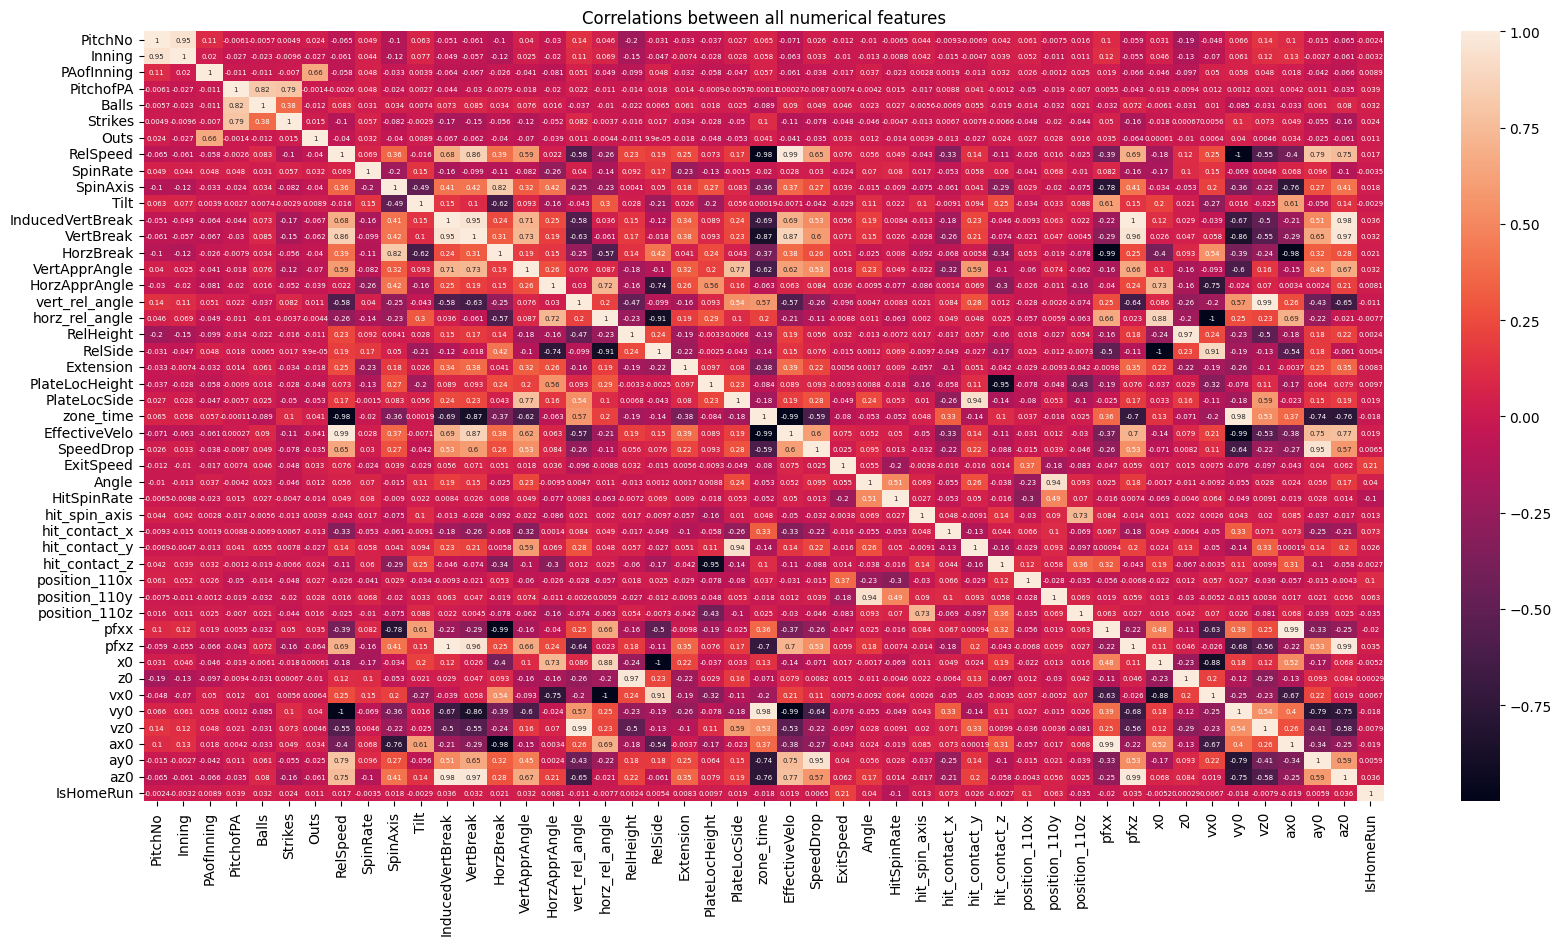

In [115]:
cor = data[numerical_features].corr()
plt.figure(figsize=(20,10))
sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, annot=True, annot_kws={"size":5})
plt.title("Correlations between all numerical features")

There are a lot of features, so the graph is quite small. However, the colors, numbers and labels are still visible, which shows us a few interesting correlations, some of which are expected:

1. position_110y is highly correlated with the angle, which makes sense, as angle will result in the ball going towards left or right field
2. hit_contact_y is highly correlated with placelocside, which makes sense - the horizontal positioning of the hit will be the same as where the pitch ends up over the plate
3. Interestingly, position_110y is pretty correlated with the HitSpinRate as well. Perhaps the spin of the ball is correlated with where it ends up left-right?

Unfortunately, there are not any immediately obvious features to engineer from this heatmap. However, we can still use our knowledge of baseball (and our need for numerical variables) to do some feature engineering.

### Feature Engineering

##### Turning Left/Right into Numbers

Now we get to feature engineering. There are some notable categorical features that we want to one-hot encode or turn into binary variables, to allow convenient modeling. These operations are shown below.

Categorical features:  
PitcherThrows: "L" or "R"  
PitcherTeam: "TEX_LON" or other  
BatterSide: "L" or "R"  
BatterTeam: "TEX_LON" or other  
inning_half: "Top" or "Bottom"  

We want to numerical-ize these variables, because they are useful information and also binary. An L and R can easily be converted into a 0 or 1.


In [116]:
#Just for reference
to_numerical = [
    "PitcherThrows",
    "PitcherTeam",
    "BatterSide",
    "BatterTeam",
    "inning_half",
    "TaggedPitchType"
]

#Make the handed-ness, teams, and half a boolean value
data.loc[:,"PitcherThrows"] = data["PitcherThrows"].map({"L":0, "R":1})
data.loc[:,"PitcherTeam"] = (data["PitcherTeam"] == "TEX_LON").astype(int)
data.loc[:,"BatterSide"] = data["BatterSide"].map({"L":0, "R":1})
data.loc[:,"BatterTeam"] = (data["BatterTeam"] == "TEX_LON").astype(int)
data.loc[:,"inning_half"] = data["inning_half"].map({"Top":0, "Bottom":1})

data.head()

,PitchNo,Inning,inning_half,PAofInning,PitchofPA,PitcherThrows,PitcherTeam,BatterSide,BatterTeam,Balls,...,pfxz,x0,z0,vx0,vy0,vz0,ax0,ay0,az0,IsHomeRun
0,357,9,0,3,3,1,1,0,0,1,...,11.23,0.01,6.04,1.96,-128.39,-7.87,-9.46,26.93,-13.46,0
1,158,5,0,1,2,1,1,0,0,0,...,9.25,-2.43,6.12,7.30,-133.46,-5.53,-9.15,27.18,-15.40,0
2,252,6,1,7,3,1,0,1,1,1,...,7.87,-1.13,6.41,1.61,-127.56,-4.87,-7.68,25.99,-19.20,0
3,197,5,1,10,3,1,0,1,1,0,...,-5.93,-1.38,6.27,4.20,-113.24,-3.16,5.52,24.10,-39.73,0
4,281,7,1,2,6,1,0,1,1,3,...,6.62,-1.83,5.79,2.06,-131.64,-4.69,0.41,27.55,-20.54,0


##### Create handed-ness matchup feature

We also want to engineer this new feature indicating the handed-ness matchup. Statistically, L/L or R/R favors the pitcher while L/R or R/L favors the batter. We want to represent this as a new feature!

In [117]:
data.loc[:,"SideMatchup"] = (data["PitcherThrows"] == data["BatterSide"]).astype(int)

print(data[["PitcherThrows", "BatterSide", "SideMatchup"]].head())
data.shape

  PitcherThrows BatterSide  SideMatchup
0             1          0            0
1             1          0            0
2             1          1            1
3             1          1            1
4             1          1            1


C:\Users\kenne\AppData\Local\Temp\ipykernel_29212\1722359646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,"SideMatchup"] = (data["PitcherThrows"] == data["BatterSide"]).astype(int)


(10202, 54)

As shown above, the sidematchup is now indicative of a batter advantage (0) or pitcher advantage (1).

##### Ordinally encoding the pitch type

One final categorical feature that would be interesting to use in our analyses is the pitch type. Currently, the data is in the form of strings, as "slider", "fastball" etc. Since this feature is so important, we will ordinally encode it. We do acknowledge the limitations with ordinal encoding (ie an inherent numerical relation between the values), however we determined that this was better than inflating our feature count by 7 with one-hot encoding.

In [126]:
from sklearn.preprocessing import OrdinalEncoder

#Print the unique values
print(data[["TaggedPitchType"]].value_counts())

#Remove the Knuckleball and Four-seam, since they only have 1 row each
knuckle_four_rows = data[data["TaggedPitchType"].isin(["Knuckleball", "Four-Seam"])].index
data = data.drop(knuckle_four_rows)

print()

#Print the unique values after
print(data[["TaggedPitchType"]].value_counts())

TaggedPitchType
Fastball           4039
Slider             2776
Sinker             1574
ChangeUp            960
Curveball           496
Cutter              330
Splitter             25
Name: count, dtype: int64

TaggedPitchType
Fastball           4039
Slider             2776
Sinker             1574
ChangeUp            960
Curveball           496
Cutter              330
Splitter             25
Name: count, dtype: int64


Now that we've reduced the noise, we can go ahead and apply ordinal encoding

In [130]:
#Encode the TaggedPitchType Ordinally
encoder = OrdinalEncoder()
data["OrdinalPitch"] = encoder.fit_transform(data[["TaggedPitchType"]])
pd.DataFrame(data[["TaggedPitchType", "OrdinalPitch"]])

,TaggedPitchType,OrdinalPitch
0,Fastball,3.0
1,Fastball,3.0
2,Fastball,3.0
3,Curveball,1.0
4,Fastball,3.0
...,...,...
10225,Fastball,3.0
10226,Fastball,3.0
10227,Fastball,3.0
10228,Fastball,3.0


##### Data ready for modeling

With our cleaning, exploration, and feature engineering done, our data is now ready to be modeled!

In [138]:
print("Value counts of home runs at UT home games")
print(data[["IsHomeRun"]].value_counts())

labels = data["IsHomeRun"]
data = data.drop(columns=["IsHomeRun"]) #Drop to re-append to the end

data["IsHomeRun"] = labels
labels = labels

data.head()

Value counts of home runs at UT home games
IsHomeRun
0            10123
1               77
Name: count, dtype: int64


,PitchNo,Inning,inning_half,PAofInning,PitchofPA,PitcherThrows,PitcherTeam,BatterSide,BatterTeam,Balls,...,z0,vx0,vy0,vz0,ax0,ay0,az0,SideMatchup,OrdinalPitch,IsHomeRun
0,357,9,0,3,3,1,1,0,0,1,...,6.04,1.96,-128.39,-7.87,-9.46,26.93,-13.46,0,3.0,0
1,158,5,0,1,2,1,1,0,0,0,...,6.12,7.30,-133.46,-5.53,-9.15,27.18,-15.40,0,3.0,0
2,252,6,1,7,3,1,0,1,1,1,...,6.41,1.61,-127.56,-4.87,-7.68,25.99,-19.20,1,3.0,0
3,197,5,1,10,3,1,0,1,1,0,...,6.27,4.20,-113.24,-3.16,5.52,24.10,-39.73,1,1.0,0
4,281,7,1,2,6,1,0,1,1,3,...,5.79,2.06,-131.64,-4.69,0.41,27.55,-20.54,1,3.0,0


## Modeling

### Decision Trees (Cristian)

In [71]:
pd.DataFrame(data.isnull().sum())
data = data.drop_duplicates()

PitchNo                0
Inning                 0
inning_half            0
PAofInning             0
PitchofPA              0
PitcherThrows          0
PitcherTeam            0
BatterSide             0
BatterTeam             0
Balls                  0
Strikes                0
Outs                   0
RelSpeed              28
SpinRate              29
SpinAxis              28
Tilt                  28
InducedVertBreak      28
VertBreak             28
HorzBreak             28
VertApprAngle         28
HorzApprAngle         28
vert_rel_angle        28
horz_rel_angle        28
RelHeight             28
RelSide               28
Extension             29
PlateLocHeight        28
PlateLocSide          28
zone_time             28
EffectiveVelo         28
SpeedDrop             28
ExitSpeed           7680
Angle               7680
HitSpinRate         8133
hit_spin_axis       8172
hit_contact_x       7721
hit_contact_y       7721
hit_contact_z       7721
position_110x       9249
position_110y       9249


Now lets deal with null values. Here we will remove columns with too many nulls and replace the remaining nulls with their average. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# dropping the position columns because over 800 are null for position
# and over 500 are null for HitSpinRate
position_columns = ['position_110x', 'position_110y', 'position_110z', 'HitSpinRate']
# data = data.drop(columns=position_columns)

# Columns with 2 null values
columns_with_2_nulls = [
    'RelSpeed', 'SpinRate', 'SpinAxis', 'Tilt', 'InducedVertBreak', 'VertBreak', 
    'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'vert_rel_angle', 'horz_rel_angle', 
    'RelHeight', 'RelSide', 'PlateLocHeight', 'PlateLocSide', 'zone_time', 
    'EffectiveVelo', 'SpeedDrop', 'pfxx', 'pfxz', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 
    'ax0', 'ay0', 'az0'
]

# Identify rows with null values in these columns
rows_with_nulls = data[columns_with_2_nulls].isnull().any(axis=1)

# Check if these rows are the same across all columns
common_null_rows = data[rows_with_nulls].index

# If all rows are the same, remove them
if len(common_null_rows) == 2:
    data = data.drop(index=common_null_rows)

# Separate numerical and non-numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
non_numerical_columns = data.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values for numerical columns with the mean
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

# Fill missing values for non-numerical columns with the mode
for column in non_numerical_columns:
    data[column] = data[column].fillna(data[column].mode()[0])

# Verify the changes
print("Shape:", data.shape)
pd.DataFrame(data.isnull().sum()).transpose()

# One-hot encode non-numerical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity
encoded_features = encoder.fit_transform(data[non_numerical_columns])
encoded_feature_names = encoder.get_feature_names_out(non_numerical_columns)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=data.index)

# Concatenate the original numerical columns with the encoded features
data = pd.concat([data[numerical_columns], encoded_df], axis=1)

# Verify the changes
print("Shape:", data.shape)
data.head()

Empty DataFrame
Columns: [PitchNo, Inning, inning_half, PAofInning, PitchofPA, PitcherThrows, PitcherTeam, BatterSide, BatterTeam, Balls, Strikes, Outs, RelSpeed, SpinRate, SpinAxis, Tilt, InducedVertBreak, VertBreak, HorzBreak, VertApprAngle, HorzApprAngle, vert_rel_angle, horz_rel_angle, RelHeight, RelSide, Extension, PlateLocHeight, PlateLocSide, zone_time, EffectiveVelo, SpeedDrop, ExitSpeed, Angle, hit_spin_axis, hit_contact_x, hit_contact_y, hit_contact_z, pfxx, pfxz, x0, y0, z0, vx0, vy0, vz0, ax0, ay0, az0, IsHomeRun, Sidematchup]
Index: []

[0 rows x 50 columns]
PitchNo             0
Inning              0
inning_half         0
PAofInning          0
PitchofPA           0
PitcherThrows       0
PitcherTeam         0
BatterSide          0
BatterTeam          0
Balls               0
Strikes             0
Outs                0
RelSpeed            0
SpinRate            0
SpinAxis            0
Tilt                0
InducedVertBreak    0
VertBreak           0
HorzBreak           0
Vert

In [ ]:
# Inspect the numerical columns
data = data.drop(columns=['PitchNo', 'y0'], errors='ignore')
pd.set_option('display.max_columns', None)
data.describe()

data['SpinRate_norm'] = data['SpinRate'] / 1000  # Normalize to range ~[0.9, 3.5]

data['SpinAxis_norm'] = data['SpinAxis'] / 360  # Scale down by dividing by 360

# 4. Tilt
data['Tilt_norm'] = data['Tilt'] / 1000  # Normalize to range ~[3.6, 45.9]

data['ExitSpeed_norm'] = data['ExitSpeed'] / 100  # Normalize to range ~[0.2, 1.2]

# Calculate the range of each column
column_ranges = data.max() - data.min()

columns_to_round_2_decimal = column_ranges[column_ranges <= 30].index

# Round columns with a range under 30 to 2 decimal places
data[columns_to_round_2_decimal] = data[columns_to_round_2_decimal].round(2)

# Identify columns with a range greater than 10
columns_to_round_1_decimal = column_ranges[column_ranges > 30].index

# Round columns with a range greater than 10 to 1 decimal place
data[columns_to_round_1_decimal] = data[columns_to_round_1_decimal].round(1)

# Preview the processed DataFrame
print(data.head())

    Inning  PAofInning  PitchofPA  PitcherThrows  BatterSide  Balls  Strikes  \
0        9           3          3              1           0      1        1   
1        5           1          2              1           0      0        1   
6        6           4          3              1           0      1        1   
10       8           1          3              1           1      0        2   
15       3           1          1              0           1      0        0   

    Outs  RelSpeed  SpinRate  SpinAxis     Tilt  InducedVertBreak  VertBreak  \
0      2      88.6    2158.0     209.7   3600.0              19.8      -16.7   
1      0      92.0    2445.0     207.9   3600.0              16.3      -16.6   
6      0      78.2    2150.0      41.3  27000.0             -10.8      -57.2   
10     0      83.0    2214.0      30.8  25200.0              -6.4      -48.1   
15     0      80.6    1682.0      88.4  32400.0               1.1      -43.0   

    HorzBreak  VertApprAngle  HorzAppr

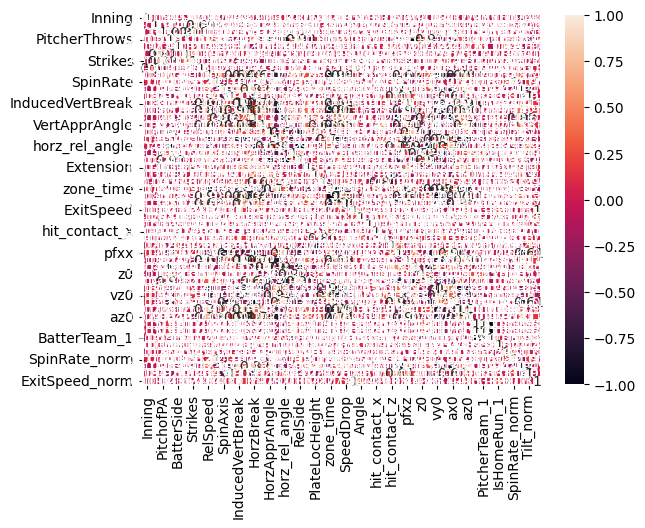

In [63]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

### SVM

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Remove the target variable 'IsHomeRun' from features (X) and store it separately (y)
X = data.drop('IsHomeRun', axis=1)
y = data['IsHomeRun']

# Split to get the training and the testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Scale the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Since there is more non-homeruns than homeruns we need to use SMOTE to create a balanced training dataset
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Train and predict for the SVM model
print("Training SVM model...")
svm_model = SVC()
svm_model.fit(X_train_balanced, y_train_balanced)
svm_pred = svm_model.predict(X_test_scaled)

#Create and display results for classification report and confusion matrix
print("\nSVM Model Results:")
print("-----------------")
print(classification_report(y_test, svm_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, svm_pred))

Training SVM model...

SVM Model Results:
-----------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       373
           1       0.60      0.32      0.41        19

    accuracy                           0.96       392
   macro avg       0.78      0.65      0.70       392
weighted avg       0.95      0.96      0.95       392


Confusion Matrix:
[[369   4]
 [ 13   6]]


Through multiple iterations we can see a some consistencies in the results shown. For 1, the model can accurately predict when the play isn't a home-run with over a 90% success rate. For accurately predicting a home-run the model has ranges with at most having a 60% rate and the least being a 35% rate of success.

Training Random Forest model...


<Axes: xlabel='importance', ylabel='feature'>

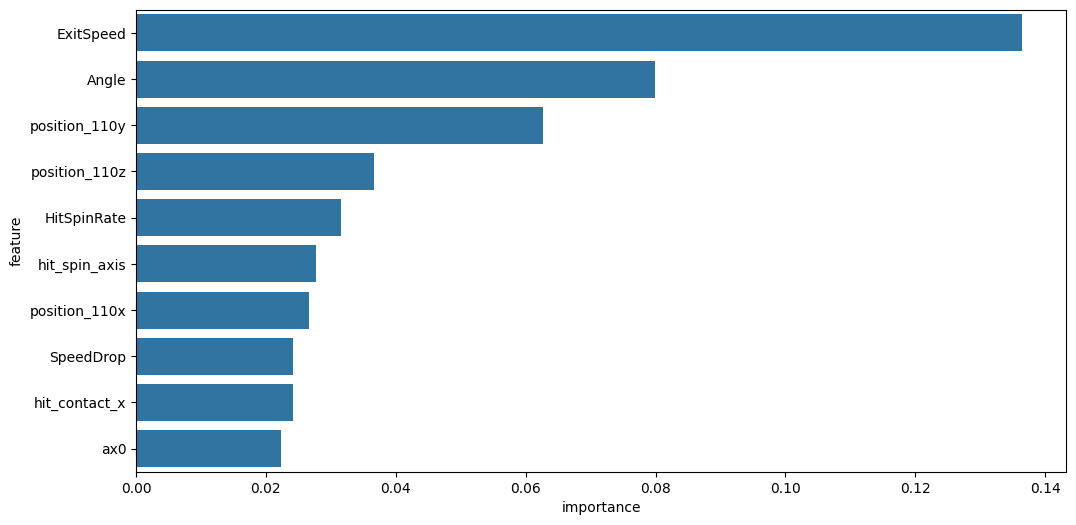

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)

# Finding which features are the most important in determining a home-run
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plotting the ten most important features in the dataset for determining a home-run
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10),x='Importance',y='Feature')

When looking at the data, we can see that the results are actually relevant to what we know about baseball. For example, numbers like the ExitSpeed (speed of ball after being hit) and Angle (when hit) are important because they give a great indication of when a ball has enough power/height to make it past the field and into the stands.

### Naive Bayes

Usually Naive Bayes is used for categorical features, however we can make it work with continuous data through binning. First we will start by reading in the data.

In [28]:
data = pd.read_csv('data.csv')
pd.set_option('display.max_columns', None)

data.head()

Here we can see that the PlayResult label has inconsistent casing so we will convert it all to lowercase before transforming it

In [67]:
data['PlayResult'].unique()

labels = (data['PlayResult'].str.lower())

labels.unique()

y = (labels == 'homerun').astype(int)
y.unique()

array(['Undefined', 'Strikeout', 'Single', 'FieldersChoice', 'Out',
       'Double', 'Walk', 'Sacrifice', 'HomeRun', 'Error', 'Triple',
       'StolenBase', 'CaughtStealing', 'error', 'SIngle', 'homerun'],
      dtype=object)

array(['undefined', 'strikeout', 'single', 'fielderschoice', 'out',
       'double', 'walk', 'sacrifice', 'homerun', 'error', 'triple',
       'stolenbase', 'caughtstealing'], dtype=object)

array([0, 1])

## Outcome